# Estimation of the carbon storage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import swisslandstats as sls

## Load LULC dataset

In [2]:
vaud_ldf = sls.read_csv('data/vaud_ldf.csv')

## Load carbon pools

Reading multiindexed csv with blanks (see https://stackoverflow.com/questions/30322581/pandas-read-multiindexed-csv-with-blanks)

In [3]:
# TODO: fix ugly hardcoded names

def correct_columns_from_csv(df):
    columns = pd.DataFrame(df.columns.tolist())
    columns.loc[columns[0].str.startswith('Unnamed'), 0] = np.nan
    columns[0] = columns[0].fillna(method='ffill')
    mask = pd.isnull(columns[0])
    columns[0] = columns[0].fillna('')
    columns.loc[mask, [0,1]] = columns.loc[mask, [1,0]].values
    df_idx = pd.MultiIndex.from_tuples(columns.to_records(index=False).tolist(), names=['stock', 'year'])
    df_idx = df_idx.set_levels(df_idx.levels[1].astype(int), level='year')
    return df_idx

def correct_index_from_csv(df):
    index = pd.DataFrame(df.index.tolist())
    index[0] = index[0].fillna(method='ffill')
    df.index = pd.MultiIndex.from_tuples(index.to_records(index=False).tolist(), names=['LULC', 'prodreg', 'elevation'])

    # index lulc as int
    df.index = df.index.set_levels(df.index.levels[0].astype(int), level='LULC')
    
    # if map_prodreg:
    #     # index prodreg names instead of numbers
    #     prodreg_name_map = {1: 'Jura', 2: 'Central Plateau', 3: 'Pre Alps', 4: 'Alps', 5: 'Southern Alps'}
    #     df.index = df.index.set_levels(df.index.levels[1].map(lambda x: prodreg_name_map[x]), level='prodreg')
    
    return df.index

We want to obtain a dataframe with the Mg/hectare of carbon stored in five fundamental pools for each LULC class, stratified by production region and elevation zone.
We separate for those coefficients that vary yearly `variable_coeff_df` and those that don not `constant_coeff_df`

In [4]:
variable_coeff_df = pd.read_csv('data/variable_coeffs.csv', header=[0,1], index_col=[0,1,2])

variable_coeff_df.columns = correct_columns_from_csv(variable_coeff_df)
variable_coeff_df.index = correct_index_from_csv(variable_coeff_df)

variable_coeff_df = variable_coeff_df.unstack(0).stack(1)
variable_coeff_df.head()

stock                  C_dead_wood      C_litter      C_living_biomass        \
LULC                            12   21       12   21               12    21   
prodreg elevation year                                                         
1       1         1979        5.84  0.0     9.51  0.0           126.76  4.34   
                  1980        5.84  0.0     9.51  0.0           126.76  4.34   
                  1981        5.84  0.0     9.51  0.0           126.76  4.34   
                  1982        5.84  0.0     9.51  0.0           126.76  4.34   
                  1983        5.84  0.0     9.51  0.0           126.76  4.34   

stock                  C_mineral_soil       C_organic_soil         
LULC                               12    21             12     21  
prodreg elevation year                                             
1       1         1979          82.65  53.4          145.6  240.0  
                  1980          82.65  53.4          145.6  240.0  
                  1

In [5]:
constant_coeff_df = pd.read_csv('data/constant_coeffs.csv', header=0, index_col=[0,1,2])

constant_coeff_df.index = correct_index_from_csv(constant_coeff_df)
constant_coeff_df = constant_coeff_df.unstack(0)
constant_coeff_df.head()

                  C_living_biomass                                          \
LULC                            11     13    31     32    33     34     35   
prodreg elevation                                                            
1       1                     10.0  38.53  7.08  20.45  3.74  20.45  24.62   
        2                     10.0  51.10  6.00  20.45  3.74  20.45  24.62   
        3                      7.5  51.34  7.95  20.45  3.74  20.45  24.62   
2       1                     10.0  20.45  7.08  20.45  3.74  20.45  24.62   
        2                     10.0  35.83  6.00  20.45  3.74  20.45  24.62   

                                   ...  C_organic_soil                       \
LULC                 36    37   41 ...              35     36     37     41   
prodreg elevation                  ...                                        
1       1          7.16  7.87  0.0 ...           240.0  240.0  240.0  240.0   
        2          7.16  7.87  0.0 ...           240.0  240

## Get yearly coefficient tables

In [6]:
# TODO: DRY the stratification strategy with Python iterators

def get_stratum_ser(ldf, lulc_column, year_column):
    stratum_ser = pd.Series(0, index=ldf.index, name='stratum')
    for (prodreg, elev, orgsoil, lulc, year), stratum_df in ldf.groupby(
            ['prodreg', 'elevation', 'orgsoil', lulc_column, year_column]):
        stratum_code = int(str(prodreg) + str(elev) + str(orgsoil) + str(lulc))
        stratum_ser.loc[stratum_df.index] = stratum_code

    return stratum_ser
    
def get_coeff_df(ldf, lulc_column, year_column, variable_coeff_df, constant_coeff_df):
    
    variable_lulc_columns = list(variable_coeff_df.columns.levels[1])
    constant_lulc_columns = list(constant_coeff_df.columns.levels[1])

    indep_stock_columns = list(variable_coeff_df.columns.levels[0][:3])    

    coeff_df = pd.DataFrame(columns=indep_stock_columns + ['C_soil'])
    
    for (prodreg, elev, orgsoil, lulc, year), stratum_df in ldf.groupby(
            ['prodreg', 'elevation', 'orgsoil', lulc_column, year_column]):
        stratum_lulc_code = int(str(prodreg) + str(elev) + str(orgsoil) + str(lulc))
        # ldf.loc[stratum_df.index, stratum_lulc_col] = stratum_lulc_code
        if lulc in variable_lulc_columns:
            coeff_row = variable_coeff_df.loc[(prodreg, elev, year)]
        else:
            coeff_row = constant_coeff_df.loc[(prodreg, elev)]
        for stock_col in indep_stock_columns:
            coeff_df.loc[stratum_lulc_code, stock_col] = coeff_row[(stock_col, lulc)]
        if orgsoil == 0:
            coeff_df.loc[stratum_lulc_code, 'C_soil'] = coeff_row[('C_mineral_soil', lulc)]
        else:
            coeff_df.loc[stratum_lulc_code, 'C_soil'] = coeff_row[('C_organic_soil', lulc)]
    
    return coeff_df

## Invest

In [7]:
from natcap.invest import carbon

Create a workspace directory

In [8]:
import os

workspace_dir = 'invest_carbon_output'
if not os.path.exists(workspace_dir):
    os.makedirs(workspace_dir)

In [9]:
import rasterio

Map our pools to Invest four fundamental pools

In [10]:
stock_map = {'C_dead_wood': 'C_dead', 'C_litter': 'C_below', 'C_living_biomass': 'C_above', 'C_soil': 'C_soil'}

Prepare Invest inputs: we will run invest for each LULC snapshot in order to evaluate the evolution of the carbon stock (and assess the effects of LULC and urbanization)

In [11]:
# ACHTUNG: ensure that the column order is consistent for lulc and year columns
lulc_columns = vaud_ldf.columns[vaud_ldf.columns.str.startswith('LULC')]
year_columns = vaud_ldf.columns[vaud_ldf.columns.str.startswith('FJ')]

for lulc_column, year_column in zip(lulc_columns, year_columns):
    # Map the strata to their corresponding pixels
    stratum_lulc_column = 'STRAT_' + lulc_column
    vaud_ldf[stratum_lulc_column] = get_stratum_ser(vaud_ldf, lulc_column, year_column)

    # Export GeoTiff of the LULC strata
    lulc_cur_path = os.path.join(workspace_dir, lulc_column + '_input.tif')
    vaud_ldf.to_geotiff(lulc_cur_path, stratum_lulc_column, dtype=rasterio.uint32)

    # Get stratified coefficients (with columns mapped to invest names)
    coeff_df = get_coeff_df(vaud_ldf, lulc_column, year_column, variable_coeff_df, constant_coeff_df)
    coeff_df.columns = coeff_df.columns.map(lambda col: stock_map[col])
    # lulc code column must be named lucode (for the invest carbon model)
    coeff_df.index = coeff_df.index.set_names('lucode')
    # export it to csv
    carbon_pools_path = os.path.join(workspace_dir, 'coeffs_' + lulc_column)
    coeff_df.to_csv(carbon_pools_path)


    args = {'workspace_dir': workspace_dir, 'results_suffix': lulc_column, 'lulc_cur_path': lulc_cur_path, 'carbon_pools_path': carbon_pools_path}
    carbon.execute(args)

## Postprocessing

In [12]:
import glob

We can now plot the evolution of our carbon stock

Text(0,0.5,'Mg of stored carbon')

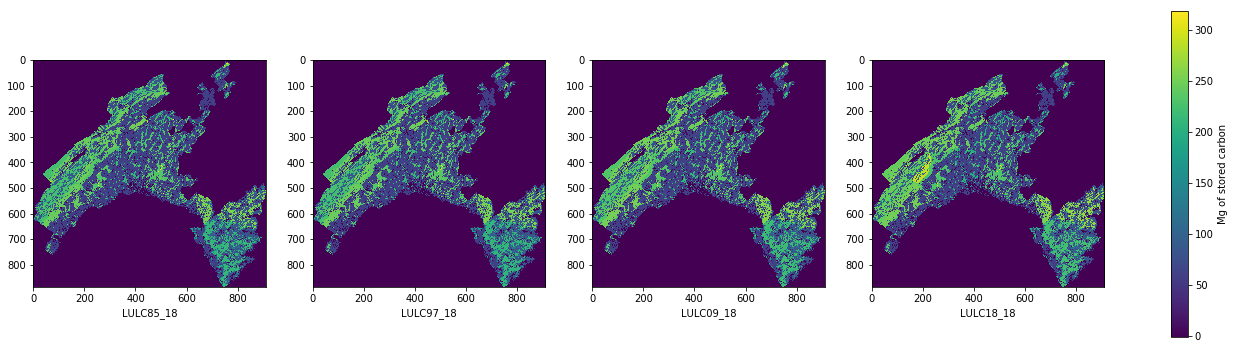

In [13]:
fig, axes = plt.subplots(1, len(lulc_columns), figsize=(6 * len(lulc_columns), 6))
carbon_stock = np.zeros(len(lulc_columns))
for i, lulc_column in enumerate(lulc_columns):
    invest_output_fp = glob.glob(os.path.join(workspace_dir, '*' + lulc_column + '.tif'))[0]
    with rasterio.open(invest_output_fp, 'r') as src:
        arr = src.read(1)
    im = axes[i].imshow(arr)
    axes[i].set_xlabel(lulc_column)
    # This is the total amount of carbon storage in Mg
    carbon_stock[i] = np.nansum(arr)


cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.ax.set_ylabel("Mg of stored carbon")

[Text(0,0,'LULC85_18'),
 Text(0,0,'LULC97_18'),
 Text(0,0,'LULC09_18'),
 Text(0,0,'LULC18_18')]

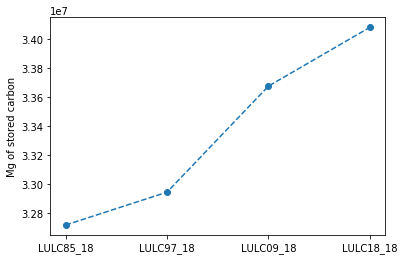

In [14]:
fig, ax = plt.subplots()
ax.plot(carbon_stock, '--o')
ax.set_ylabel("Mg of stored carbon")
ax.set_xticks(range(len(lulc_columns)))
ax.set_xticklabels(lulc_columns)